In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# os.chdir(r'/content/drive/My Drive/ECE1512_TA')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

C:\Users\13629\AppData\Local\Temp\ipykernel_34724\748991669.py:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


In [4]:
# Transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# Basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [5]:
from mnist1d_utils import *

# Dataset

In [6]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

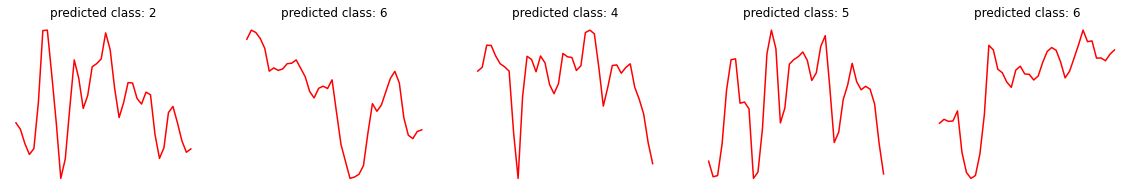

In [7]:
plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

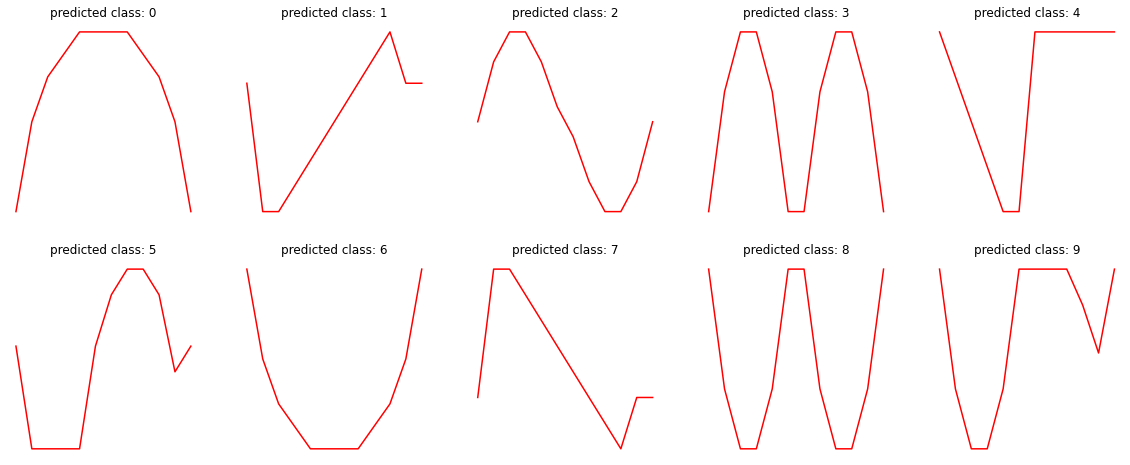

In [8]:
plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [9]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [10]:
##### Task1-Question1
weight_decay = 5e-4
model = Sequential()

model.add(Input(shape=(40,1)))
model.add(Conv1D(25, kernel_size=5, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(25, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(25, kernel_size=3, padding='same', activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))

model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [11]:
##Task1-Question2
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=tensorflow.keras.optimizers.SGD(),
              metrics=['accuracy'])

def lr_scheduler(epoch):
    base_ep = 15
    return 1e-2 * (.5 ** (epoch // base_ep))
lr_reduce_cb = keras.callbacks.LearningRateScheduler(lr_scheduler)
tensorboard_cb = keras.callbacks.TensorBoard(log_dir='log2', write_graph=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=8, min_delta=0.)

train_x=dataset['x']
train_y=dataset['y']
train_x=train_x.reshape(4000,40,1)
train_y=tensorflow.keras.utils.to_categorical(train_y, num_classes=10)

history=model.fit(x=train_x,y=train_y,epochs=200,
                    callbacks=[tensorboard_cb],                  
                    shuffle = True,
                    verbose=1)
model.save('MNIST1D.h5')
##

Epoch 1/200
125/125 [==============================] - 1s 2ms/step - loss: 3.5433 - accuracy: 0.1600
Epoch 2/200
125/125 [==============================] - 0s 2ms/step - loss: 3.4239 - accuracy: 0.1930
Epoch 3/200
125/125 [==============================] - 0s 2ms/step - loss: 3.3611 - accuracy: 0.2285
Epoch 4/200
125/125 [==============================] - 0s 2ms/step - loss: 3.3047 - accuracy: 0.2540
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 3.2468 - accuracy: 0.2718
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 3.1905 - accuracy: 0.3033
Epoch 7/200
125/125 [==============================] - 0s 2ms/step - loss: 3.1175 - accuracy: 0.3385
Epoch 8/200
125/125 [==============================] - 0s 2ms/step - loss: 3.0464 - accuracy: 0.3647
Epoch 9/200
125/125 [==============================] - 0s 2ms/step - loss: 2.9824 - accuracy: 0.3848
Epoch 10/200
125/125 [==============================] - 0s 2ms/step - loss: 2.9127 - accura

# Plotting the training progress

In [12]:
model.evaluate(train_x,train_y, verbose=1, batch_size=32)

125/125 [==============================] - 0s 872us/step - loss: 0.8661 - accuracy: 1.0000


[0.8661444783210754, 1.0]

Text(0.5, 1.0, 'loss curve')

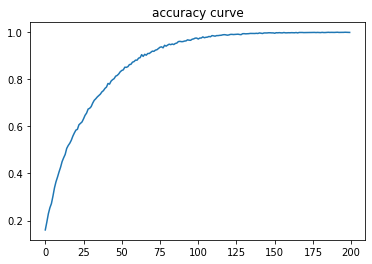

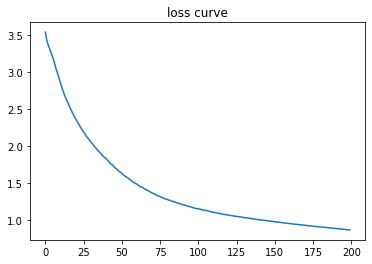

In [13]:
##Task1-Question3.a
train_acc = history.history['accuracy']
train_loss = history.history['loss']
plt.plot(train_acc)
plt.title('accuracy curve')
plt.figure()
plt.plot(train_loss)
plt.title('loss curve')

In [14]:
# Use Scikit-learn to calculate stats
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score
from sklearn.metrics import classification_report

# Q3.b get the prediction from the test set
x_test = dataset['x_test']
y_test = dataset['y_test']
x_test=x_test.reshape(1000,40,1)
# predict_classes removed in tf 2.6.0
y_pred = model.predict(x_test)
y_predicted = np.argmax(y_pred,axis=1)
print('Overall classification accuracy for all classes:'+str(np.sum(y_predicted==y_test)/y_test.shape[0]))


Overall classification accuracy for all classes:0.905


In [15]:
# Q3.c class-wise classification
for i in range(10):
    true_i=np.where(y_test==i)[0]
    res=0
    for j in true_i:
        if y_predicted[j]==i:
            res=res+1
    # TODO %.4f
    print('class '+str(i)+' accuracy:'+str(res/true_i.shape[0]))

class 0 accuracy:0.9803921568627451
class 1 accuracy:0.8653846153846154
class 2 accuracy:0.9101123595505618
class 3 accuracy:0.9433962264150944
class 4 accuracy:0.9056603773584906
class 5 accuracy:0.8673469387755102
class 6 accuracy:0.9494949494949495
class 7 accuracy:0.90625
class 8 accuracy:0.8775510204081632
class 9 accuracy:0.8431372549019608


AUC for class 0:  0.9998580724049085


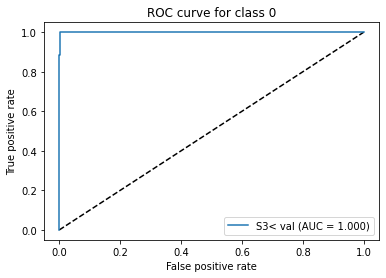

AUC for class 1:  0.9919084821428571


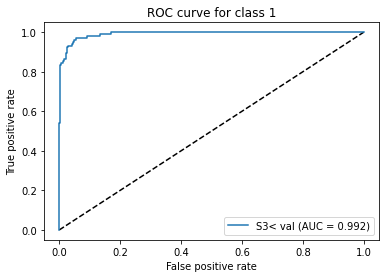

AUC for class 2:  0.9909841019252827


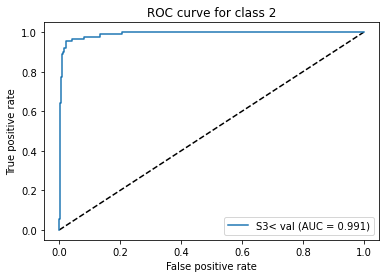

AUC for class 3:  0.9994090582921784


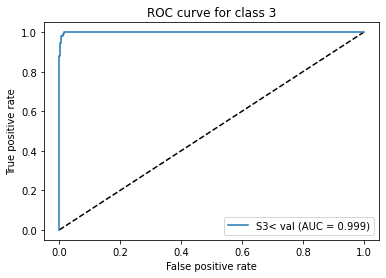

AUC for class 4:  0.99208560212739


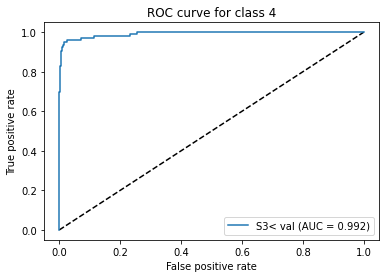

AUC for class 5:  0.9897280419928504


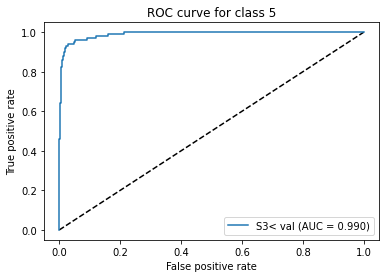

AUC for class 6:  0.9966479444836825


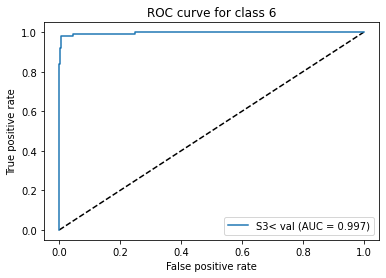

AUC for class 7:  0.9957941556047197


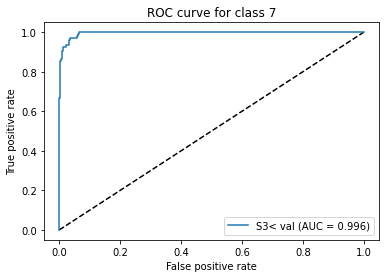

AUC for class 8:  0.99635730123535


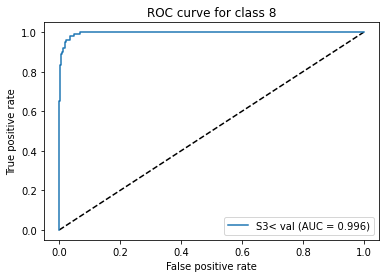

AUC for class 9:  0.9854797152714092


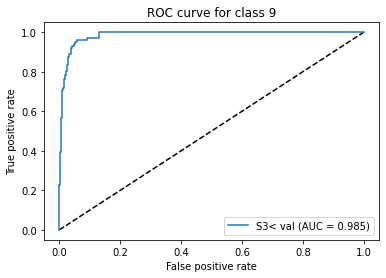

In [16]:
# Q3.d ROC and AUC curve for every class
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
# print(dataset['y_test'].shape)
real_y=np.zeros((dataset['y_test'].size,10))
for i in range(y_test.size):
    real_y[i,y_test[i]]=1
for i in range(10):
    FPR, TPR, thresholds_keras = roc_curve(real_y[:,i], y_pred[:,i]) 
    AUC = auc(FPR, TPR)  
    print("AUC for class "+str(i)+": ", AUC)
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(FPR, TPR, label='S3< val (AUC = {:.3f})'.format(AUC))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve for class '+str(i))
    plt.legend(loc='best')
    plt.show()    
    

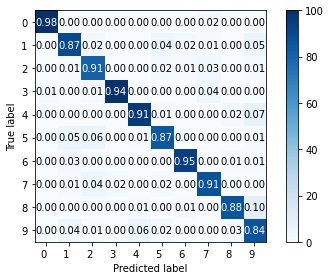

In [17]:
# Q3.e
from sklearn.metrics import confusion_matrix

# # y_predicted
cm = confusion_matrix(list(y_test), list(y_predicted))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# We want to show all ticks...
ax.set(
    xticks=np.arange(cm_normalized.shape[1]),
    yticks=np.arange(cm_normalized.shape[0]),
    # ... and label them with the respective list entries
    xticklabels=classes,
    yticklabels=classes,
    ylabel='True label',
    xlabel='Predicted label')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")
thresh = cm_normalized.max() / 2.
for i in range(cm_normalized.shape[0]):
    for j in range(cm_normalized.shape[1]):
        ax.text(j,
                i,
                format(cm_normalized[i, j], '.2f'),
                ha="center",
                va="center",
                color="white" if cm_normalized[i, j] > thresh else "black")
fig.tight_layout()

# print(cm_normalized)

In [18]:
# Q3.f
print(classification_report(y_true=y_test,y_pred=y_predicted))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       102
           1       0.87      0.87      0.87       104
           2       0.85      0.91      0.88        89
           3       0.98      0.94      0.96       106
           4       0.92      0.91      0.91       106
           5       0.89      0.87      0.88        98
           6       0.96      0.95      0.95        99
           7       0.90      0.91      0.90        96
           8       0.93      0.88      0.91        98
           9       0.77      0.84      0.81       102

    accuracy                           0.91      1000
   macro avg       0.91      0.90      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [19]:
print('Success cases:')
# print(y_test)
# print(y_predicted)
for i in range(10):
    true_i=np.where(y_test==i)[0]
    for j in true_i:
        if y_predicted[j]==i:
            print('index '+str(j)+' true class: '+str(y_test[j])+' predicted class: '+str(y_predicted[j]))


print('Failure cases:')

for i in range(10):
    true_i=np.where(y_test==i)[0]
    for j in true_i:
        if y_predicted[j]!=i:
            print('index '+str(j)+' true class: '+str(y_test[j])+' predicted class: '+str(y_predicted[j]))
            # print(y_test)

Success cases:
index 10 true class: 0 predicted class: 0
index 23 true class: 0 predicted class: 0
index 31 true class: 0 predicted class: 0
index 39 true class: 0 predicted class: 0
index 46 true class: 0 predicted class: 0
index 81 true class: 0 predicted class: 0
index 109 true class: 0 predicted class: 0
index 115 true class: 0 predicted class: 0
index 121 true class: 0 predicted class: 0
index 122 true class: 0 predicted class: 0
index 130 true class: 0 predicted class: 0
index 142 true class: 0 predicted class: 0
index 147 true class: 0 predicted class: 0
index 159 true class: 0 predicted class: 0
index 163 true class: 0 predicted class: 0
index 168 true class: 0 predicted class: 0
index 175 true class: 0 predicted class: 0
index 177 true class: 0 predicted class: 0
index 189 true class: 0 predicted class: 0
index 190 true class: 0 predicted class: 0
index 192 true class: 0 predicted class: 0
index 203 true class: 0 predicted class: 0
index 218 true class: 0 predicted class: 0
in

# Explanation

In [20]:
from xai_utils import *
from xai_methods import *

Take a test sample

Give the input to the model (Prediction)

In [21]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(x_test[index], axis=0)
print(input.shape)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(x_test[index], axis=0)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

(1, 40, 1)
Correct digit: 8
Predicted digit: 8
Confidence score for the correct label: 0.99972814


## SISE (Semantic Input Sampling for Explanation)

In [22]:
print(input.shape)
explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

(1, 40, 1)


Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

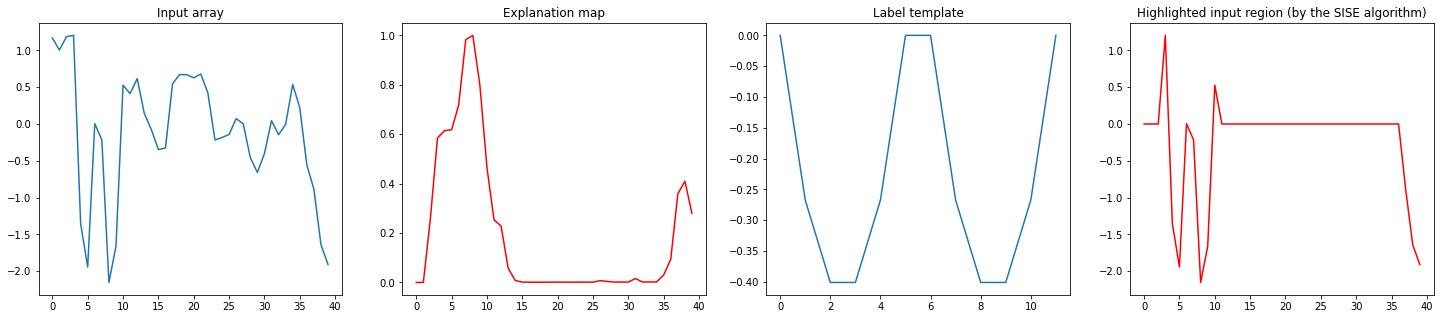

In [23]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## Grad-CAM

In [24]:
print(input.shape)
explanation = grad_cam(model, input, 'conv1d_2')

(1, 40, 1)


Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

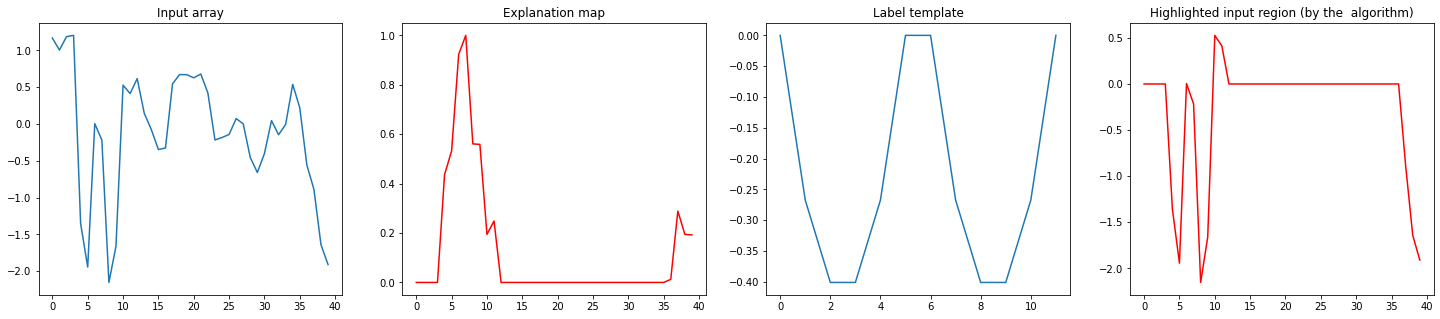

In [25]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

## Grad-CAM++

In [26]:
print(input.shape)
explanation = grad_cam_plus_plus(model,input, 'conv1d_2')

(1, 40, 1)


Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

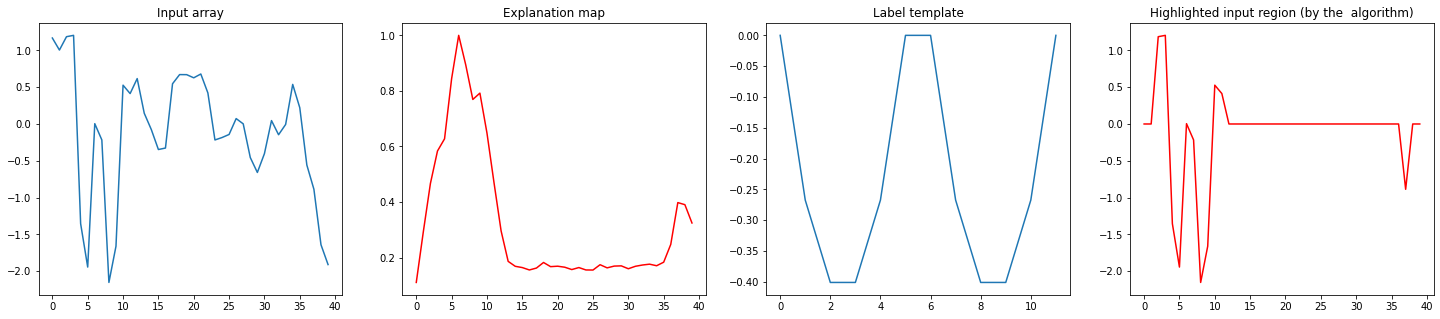

In [27]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

## LIME

In [28]:
explanation, perturbed = LIME_1d(input, model, label, num_perturb=300, sec_size=4, kernel_w=0.4, num_feats=4)

Text(0.5, 1.0, 'Perturbed Array')

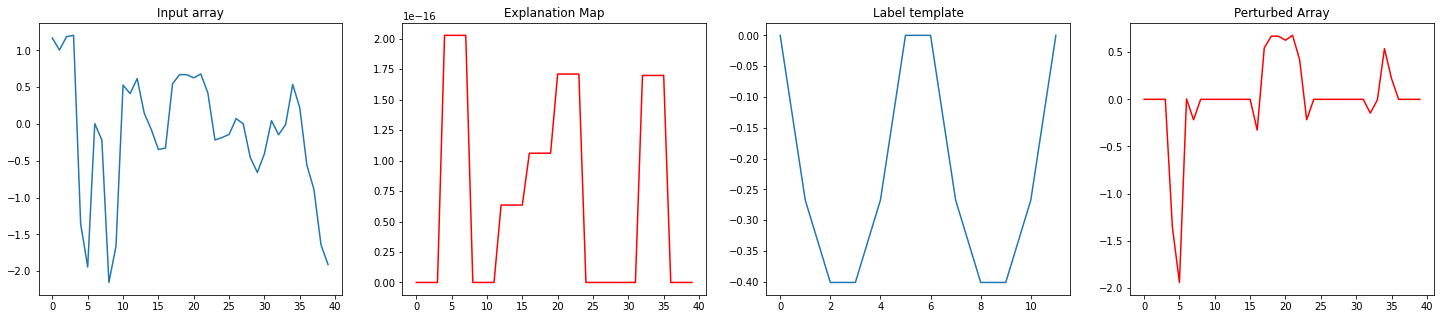

In [29]:
plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation Map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot(perturbed, 'r')
plt.title('Perturbed Array')

## Ablation-CAM

In [30]:
layer_name = 'conv1d_2'
image = input
input_model = model

explanation = ablation_cam_1d(model, input, 'conv1d_2')

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

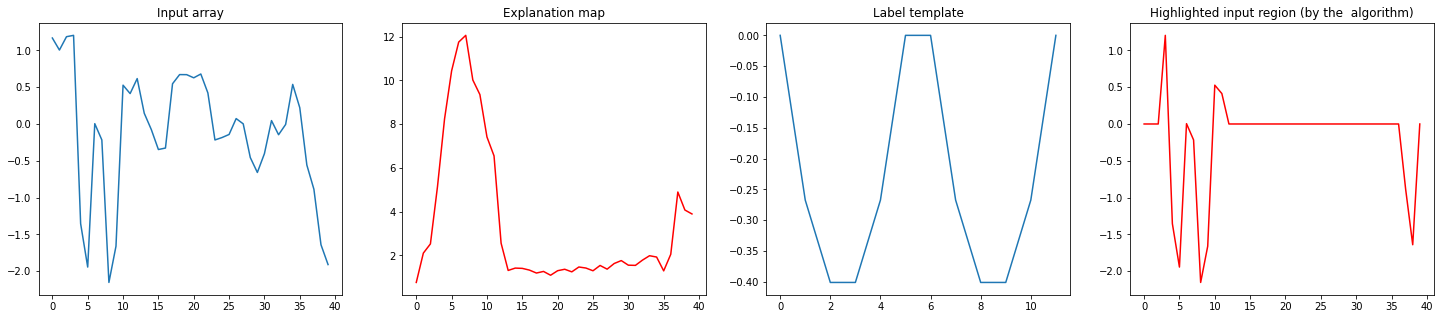

In [31]:
threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

## Quantitative evaluation

In [32]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    # Pre-processing image 
    img=images[0,:,:]
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [33]:
drop_rate = 0.
increase_rate = 0.
temp=np.expand_dims(x_test[0], axis=0)
print(np.expand_dims(x_test[0], axis=0).shape)
for index in range(100):
    prediction=model(np.expand_dims(x_test[index], axis=0)).numpy()
    explanation_map = SISE(np.expand_dims(x_test[index], axis=0), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    res = calculate_drop_increase(np.expand_dims(x_test[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate += res[0]
    increase_rate += res[1]
drop_rate /= 100
increase_rate /= 100
print(drop_rate)
print(increase_rate)

(1, 40, 1)
0.22762007020846242
0.28


In [34]:
drop_rate = 0.
increase_rate = 0.
temp=np.expand_dims(x_test[0], axis=0)
print(np.expand_dims(x_test[0], axis=0).shape)
for index in range(100):
    prediction=model(np.expand_dims(x_test[index], axis=0)).numpy()
    explanation_map = ablation_cam_1d(model, np.expand_dims(x_test[index], axis=0),  layer_name='conv1d_2')
    explanation_map = np.reshape(explanation_map, (40,1))
    res = calculate_drop_increase(np.expand_dims(x_test[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate += res[0]
    increase_rate += res[1]
drop_rate /= 100
increase_rate /= 100
print(drop_rate)
print(increase_rate)

(1, 40, 1)
0.21743762417049153
0.33


In [35]:
drop_rate = 0.
increase_rate = 0.
temp=np.expand_dims(x_test[0], axis=0)
print(np.expand_dims(x_test[0], axis=0).shape)
for index in range(100):
    prediction=model(np.expand_dims(x_test[index], axis=0)).numpy()
    explanation_map = grad_cam_plus_plus(model, np.expand_dims(x_test[index], axis=0),  layer_name='conv1d_2')
    explanation_map = np.reshape(explanation_map, (40,1))
    res = calculate_drop_increase(np.expand_dims(x_test[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate += res[0]
    increase_rate += res[1]
drop_rate /= 100
increase_rate /= 100
print(drop_rate)
print(increase_rate)

(1, 40, 1)
0.2704532058834715
0.25


In [36]:
drop_rate = 0.
increase_rate = 0.
temp=np.expand_dims(x_test[0], axis=0)
print(np.expand_dims(x_test[0], axis=0).shape)
for index in range(100):
    prediction=model(np.expand_dims(x_test[index], axis=0)).numpy()
    explanation_map = grad_cam(model, np.expand_dims(x_test[index], axis=0),  layer_name='conv1d_2')
    explanation_map = np.reshape(explanation_map, (40,1))
    res = calculate_drop_increase(np.expand_dims(x_test[index], axis=0), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate += res[0]
    increase_rate += res[1]
drop_rate /= 100
increase_rate /= 100
print(drop_rate)
print(increase_rate)

(1, 40, 1)


e:\GitHub\Dev\ECE1512_2022W_ProjectRepo_J.Xu_and_W.Xu\ProjectA\Project_A_Supp\xai_utils.py:429: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


0.38587818266078316
0.28
